In [56]:
import sys
import os
sys.path.append(os.path.abspath("../src/"))
import model.util as util
import model.models as models
import feature.make_binary_dataset as make_binary_dataset
import numpy as np
import torch
import sacred
import tqdm
import matplotlib.pyplot as plt

In [14]:
grad_ex = sacred.Experiment("grad", ingredients=[
    make_binary_dataset.dataset_ex
], interactive=True)

In [15]:
@grad_ex.capture
def get_data_loader(
    bedpath, reference_fasta_path, batch_size=1, convert_states=True
):
    """
    From the path to a gzipped BED containing values, this function returns a
    data loader.
    """
    return make_binary_dataset.data_loader_from_bedfile(
        bedpath, batch_size=batch_size, reference_fasta=reference_fasta_path,
        negative_stride=1, num_workers=0, convert_states=convert_states,
        augment=False, shuffle=False
)

In [41]:
grads, labels = [], []

@grad_ex.main
def main():
    global grads, labels
    model_path = "/users/amtseng/att_priors/models/trained_models/SPI1_DREAM/1/model_ckpt_epoch_8.pt"
    bed_path = "/users/amtseng/att_priors/data/SPI1_test_2000.tsv.gz"
    reference_fasta_path = "/users/amtseng/genomes/hg19.fasta"

    model = util.restore_model(models.BinaryTFBindingPredictor, model_path)

    if torch.cuda.is_available():
        model = model.cuda()
    
    data_loader = get_data_loader(bed_path, reference_fasta_path)
    data_loader.dataset.on_epoch_start()
            
    model.eval()  # Switch to evaluation mode
    
    num_batches = len(data_loader.dataset)
    for input_seqs, output_vals in tqdm.tqdm_notebook(data_loader, total=num_batches):
        input_seqs = util.place_tensor(torch.tensor(input_seqs)).float() 
        input_seqs = torch.transpose(input_seqs, 1, 2)

        input_seqs.requires_grad = True

        probs = model(input_seqs)

        probs.backward()

        input_grads = input_seqs.grad
        input_grads = torch.transpose(input_grads, 1, 2)

        input_grads = input_grads.cpu().detach().numpy()
        grads.append(input_grads)
        labels.append(output_vals)

    grads, labels = np.concatenate(grads), np.concatenate(labels)

In [42]:
grad_ex.run()

WARNING - grad - No observers have been added to this run
INFO - grad - Running command 'main'
INFO - grad - Started


	Reading in BED file... 0s
	Setting index... 0s
	Converting states to values... 0s
	Getting positive and negative rows... 0s
	Getting positive and negative counts... 0s
	Total coordinate counts by entry: 1000 + and 1000 -
	Total coordinate counts by row: 1000 + and 1000 -
	Estimated downsampled counts by row: 1000 + and 1000 -
	Sorting coordinates for downsampling... 0s


INFO - grad - Completed after 0:00:25


In [57]:
def dft(signal):
    N = signal.size  # Number of samples
    Fs = 1  # Sampling rate
    Ts = 1 / Fs  # Sampling period
    
    x = np.arange(0, N, Ts)  # Space vector
     
    k = np.arange(N)
    T = N / Fs
    freqs = k / T  # Two sides frequency range
    freqs = freqs[range(int(N / 2))] # one side frequency range
    
    Y = np.fft.fft(y) / N  # FFT computation and normalization
    Y = Y[range(int(N / 2))]
    return freqs, abs(Y)  # Return frequencies and magnitude of the complex coefficients

In [62]:
def plot_grad_and_fft(grads):
    assert len(grads.shape) == 2
    grads = grads.copy()  # Make a copy
    grads[grads < 0] = 0  # Pass through ReLU
    
    # Take maximum over all 4 channels for each base
    grads = np.max(grads, axis=1)
    freqs, coeffs = dft(grads)
    
    # Plot the original signal and the DFT
    fig, ax = plt.subplots(2, 1, figsize=(12, 5))
    ax[0].plot(np.arange(len(grads)), grads, color="blue")
    ax[0].set_xlabel("X")
    ax[0].set_ylabel("max(ReLU(grad))")
    ax[1].plot(freqs, coeffs, color="red")
    ax[1].set_xlabel("Frequency")
    ax[1].set_ylabel("|Frequency component|")
    plt.tight_layout()
    plt.show(block=False)

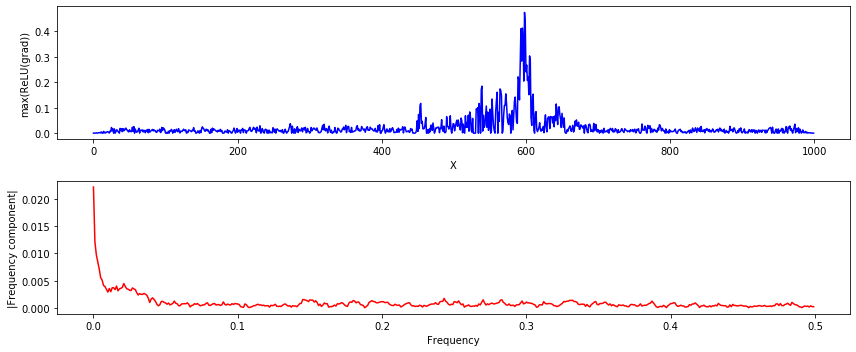

In [63]:
plot_grad_and_fft(grads[0])

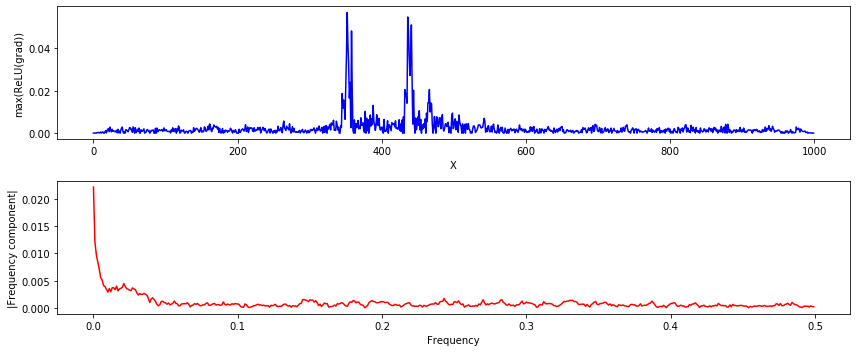

In [68]:
plot_grad_and_fft(grads[1])

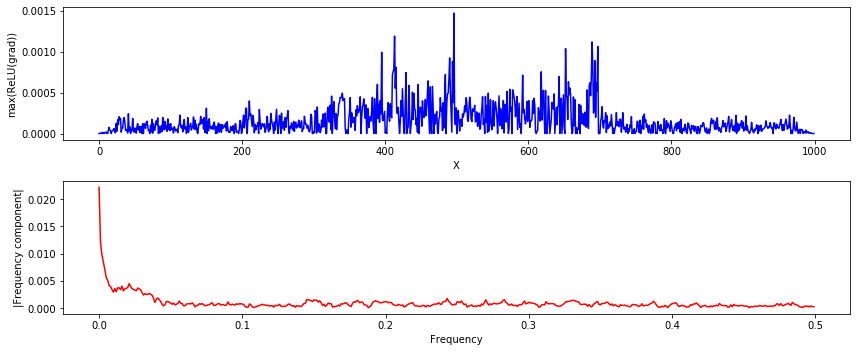

In [65]:
plot_grad_and_fft(grads[-1])

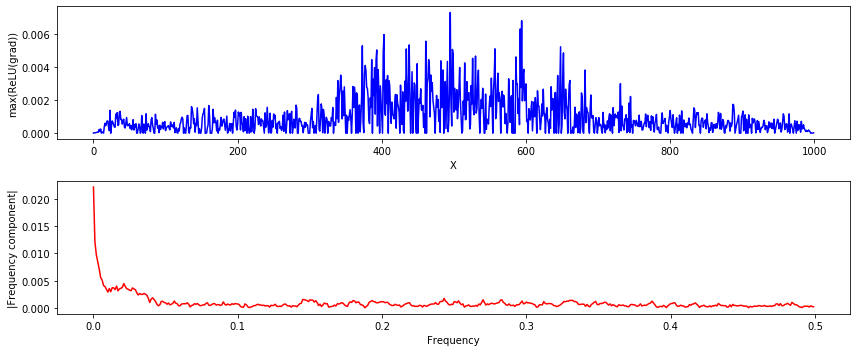

In [66]:
plot_grad_and_fft(grads[-2])